**Algoritma Adı:** StyleGan

**Dataset Adı:** Farklı Anime yüzleri




**GAN:**

GAN (Generative Adversarial Network), iki yapay zeka modelinin birbiriyle rekabet halinde çalıştığı bir yapay zeka yapısıdır. Bu yapıda "oluşturucu" (generator) ve "ayırıcı" (discriminator) adında iki ana model bulunur.

Oluşturucu (generator), gerçek verilere benzer yapay veriler üretmeye çalışır. Model, gerçekçi görüntüleri, sesleri veya metinleri sıfırdan oluşturmayı amaçlar.

Ayırıcı(discriminator) ise, karşısına çıkan verilerin gerçek mi yoksa oluşturucu tarafından üretilmiş mi olduğunu ayırt etmeye çalışır. Bu model, gerçek verilerle oluşturucunun ürettiği verileri karşılaştırır ve gerçekliğini sınıflandırır.

**STYLEGAN:**

StyleGAN ise GAN'ın temel prensiplerini kullanarak, bu prensipleri daha ileriye taşıyarak özellikle görüntü üretimi konusunda çeşitli yenilikler ve iyileştirmeler sunar.NVIDIA tarafından geliştirilen ve derin öğrenme tekniklerini kullanarak yüksek kaliteli ve gerçekçi insan yüzleri, hayvanları ve diğer nesnelerin fotoğraflarını üretmek için tasarlanmış bir yapay zeka modelidir.Bu model, temel olarak GAN (Generative Adversarial Network) prensiplerine kullanmasına ragmen bazı farklı önemli modifikasyonlar içerir. Bu modifikasyonlar, görüntü kalitesini artırmanın yanı sıra modelin esnekliğini ve kontrol edilebilirliğini iyileştirir.
Oluşturucuda yapılan değişiklikler;

1-Temel Aşamalı GAN: Model, düşük çözünürlükten başlayarak görüntüleri adım adım daha yüksek çözünürlüklere çıkarır. Her iki model de başlangıçta çok küçük boyutta (4x4) görüntüler üretmeye başlar. Model stabil hale geldikçe, görüntü boyutları yavaş yavaş artırılarak önce 8x8'e çıkarılır ve bu artış süreci, modelin istenen maksimum çözünürlüğe ulaşana kadar devam eder.Bu, modelin daha stabil ve verimli bir şekilde eğitilmesine yardımcı olur.

2-Ayarlama ve çift doğrusal örneklemenin eklenmesi: Burada görüntü kalitesini iyileştirmek için, katmanlar arası geçişlerde çift doğrusal örnekleme (bilinear sampling) ve ayarlama teknikleri kullanılır. Bu, görüntülerin daha pürüzsüz ve detaylı olmasını sağlar.

3-Haritalama ağının ve AdaIN'in (stillerin) eklenmesi: Girdi vektörlerini önce bir ara katmana (haritalama ağı) dönüştürür ve sonra bu bilgiler AdaIN ile stil bilgisine dönüştürülür. AdaIN, modelin farklı stil özelliklerini daha iyi kontrol etmesine olanak tanır, böylece çıktılar üzerinde daha fazla çeşitlilik ve tutarlılık sağlar.



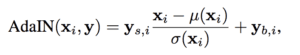

4-Jeneratöre gizli vektör girişinin kaldırılması: Başlangıç katmanlarında gizli vektör yerine sabit bir gürültü kullanılır ve bu gürültü, modelin çeşitli katmanlarına farklı stil bilgileri olarak iletilir. Bu değişiklik, görüntülerin daha tutarlı stil özellikleri göstermesine yardımcı olur.modelde görüntü sentezleme sürecini başlatmak için 4x4x512 sabit değer girişi bulunmaktadır.

5-Her bloğa gürültü eklenmesi: Her katmana küçük gürültü parçaları eklenir. Bu, görüntülerin daha gerçekçi dokular ve rastgele detaylar içermesini sağlar.

6-İlave Karıştırma düzenlemesi: Farklı katmanlarda girdilerin karıştırılması, modelin yüzler gibi karmaşık yapıları daha gerçekçi bir şekilde üretmesine imkan tanır. Örneğin, farklı yüz özelliklerinin farklı kaynaklardan alınmasıyla, sonuçlar daha çeşitli ve gerçekçi hale gelir.
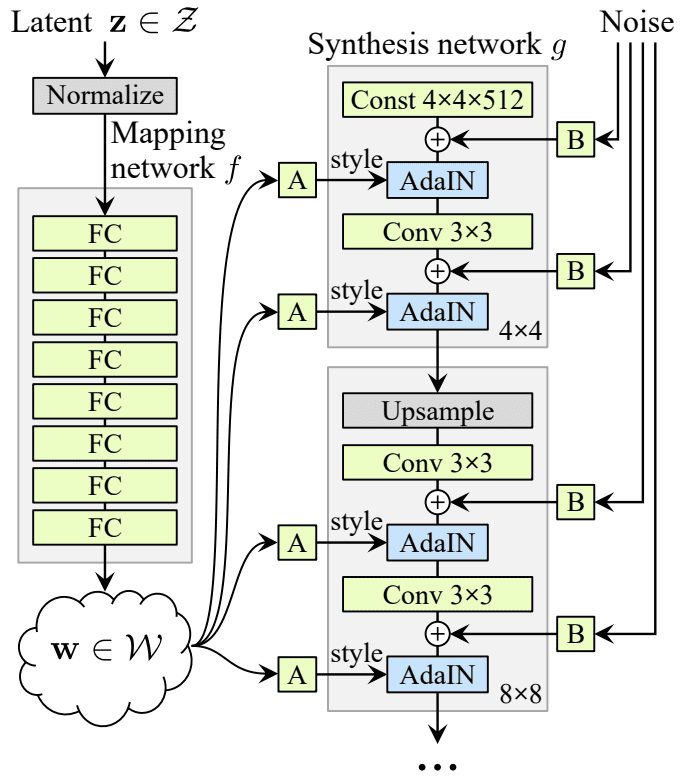

In [ ]:
pip install tensorflow_addons

In [ ]:
# Kullanılan tüm kütüphaneler içeri aktarılır.
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import sys
import keras
import random
import math

from functools import partial

import tensorflow_probability as tfp
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow_addons.layers import InstanceNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam

import gdown

from enum import Enum
from glob import glob
from functools import partial


import tensorflow_datasets as tfds

In [ ]:
#Google Drive'ı Colab ortamına bağlama
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##DATASET İÇERİĞİ TANITIMI
Bu projede veri seti kaggledan alınmıştır.SPENCER CHURCHILL kullanıcısının oluşturduğu anime yüzleri dataseti kullanılmıştır.Bu dataseti kendi drive linkimize aktararak, Drive üzerinden işlemleri gerçekleştirdik. Datasetini inceleyebilmeniz adına açık kaynaklı olarak paylaşılmıştır: https://drive.google.com/drive/u/0/folders/1qrqKuVu6D4c_4wX2lrgOxyb9ivciaPgs .


Dataset anime karakterlerinin portre görüntülerinden oluşur. Dataset toplam 24.833 yüksek çözünürlüklü anime yüz görüntüsü içerir.Görüntüler, model eğitimi için uygun hale getirilmeden önce bir dizi ön işleme işlemine tabi tutulmuştur. Bunlar arasında gereksiz arka plan bilgisinin kaldırılması ve görüntü kalitesi düşük olan veya yüz bölgesi yeterince belirgin olmayan görüntüleri veri setinden çıkardık böylece daha güzel sonuçlar elde etmiş olduk. Ayrıca,
 Her fotografın boyutları farklı olmasına rağmen kod üzerinden 64x64 piksel olarak hepsini aynı boyuta getirme işlemi yaptık. Böylece eğitim sonuçlarından daha güzel sonuçlar elde etmiş olduk.

Eğitilen StyleGAN modeli, datasetteki görüntüler kullanılarak başarılı bir şekilde eğitilmiştir.


In [ ]:
# Bu fonksiyon, log2 dönüşümü için kullanılır.
def log2(x):
    return int(np.log2(x))

# Farklı çözünürlükler için farklı toplu işlem boyutları tanımlanmıştır.
batch_sizes = {2: 16, 3: 16, 4: 16, 5: 16, 6: 16, 7: 8, 8: 4, 9: 2, 10: 1}
# Eğitim adımları, toplu işlem boyutlarına göre ayarlanır.
train_step_ratio = {k: batch_sizes[2] / v for k, v in batch_sizes.items()}

# Drive veri seti yolu
dataset_folder = '/content/drive/MyDrive/data/Anime'


# Klasör yoksa oluştur
if not os.path.exists(dataset_folder):
    os.makedirs(dataset_folder)

# Veri setini klasörden yükleyin:
ds_train = keras.utils.image_dataset_from_directory(
    dataset_folder,  # Veri setinin bulunduğu klasör
    label_mode=None,  # Etiket yok
    image_size=(64, 64),  # Görüntüleri bu boyuta yeniden boyutlandır
    batch_size=32  # Toplu işlem boyutu
)

# Görüntüleri yeniden boyutlandırmak için kullanılan fonksiyon
def resize_image(res, image):
    image = tf.image.resize(
        image, (res, res), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR
    )
    image = tf.cast(image, tf.float32) / 127.5 - 1.0
    return image

# Çözünürlüğe göre veri yükleyici oluşturan fonksiyon
def create_dataloader(res):
    batch_size = batch_sizes[log2(res)]
    dl = ds_train.map(partial(resize_image, res), num_parallel_calls=tf.data.AUTOTUNE)
    dl = dl.unbatch().shuffle(200).batch(batch_size, drop_remainder=True)
    dl = dl.cache().prefetch(tf.data.AUTOTUNE).repeat()  # Önbellekleme burada ekleniyor
    return dl

# Örnek kullanım:
dataloader = create_dataloader(64)  # 64x64 çözünürlük için veri yükleyici

Found 24833 files belonging to 1 classes.


In [ ]:
# İlk batch'i kontrol etmek için
for images in dataloader.take(1):
    print("Batch shape:", images.shape)  # Batch'in boyutunu yazdır
    print("Batch dtype:", images.dtype)  # Veri tipini kontrol et
    if tf.reduce_any(tf.math.is_nan(images)):
        print("Batch contains NaN values")  # NaN değer kontrolü

Batch shape: (16, 64, 64, 3)
Batch dtype: <dtype: 'float32'>


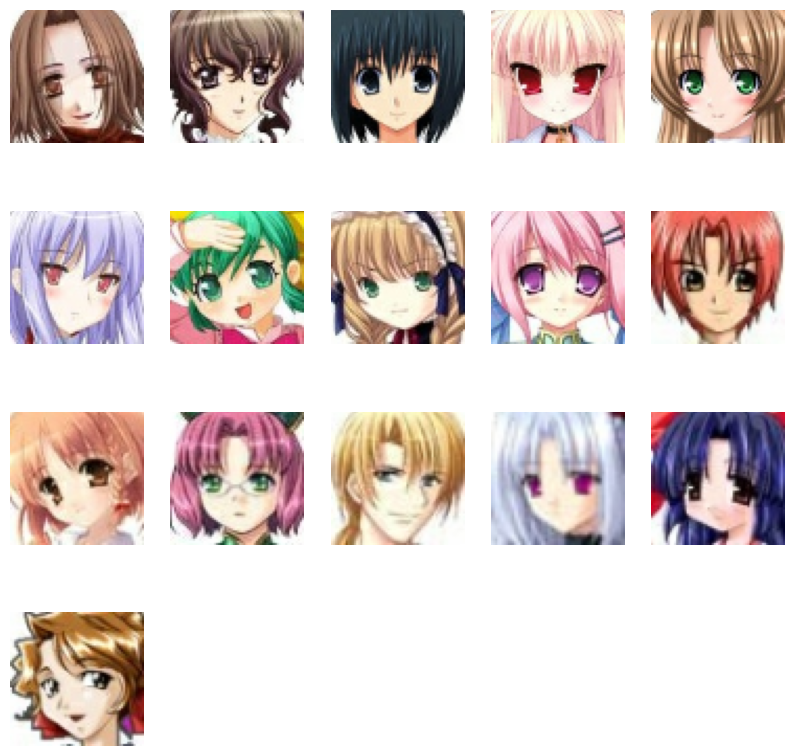

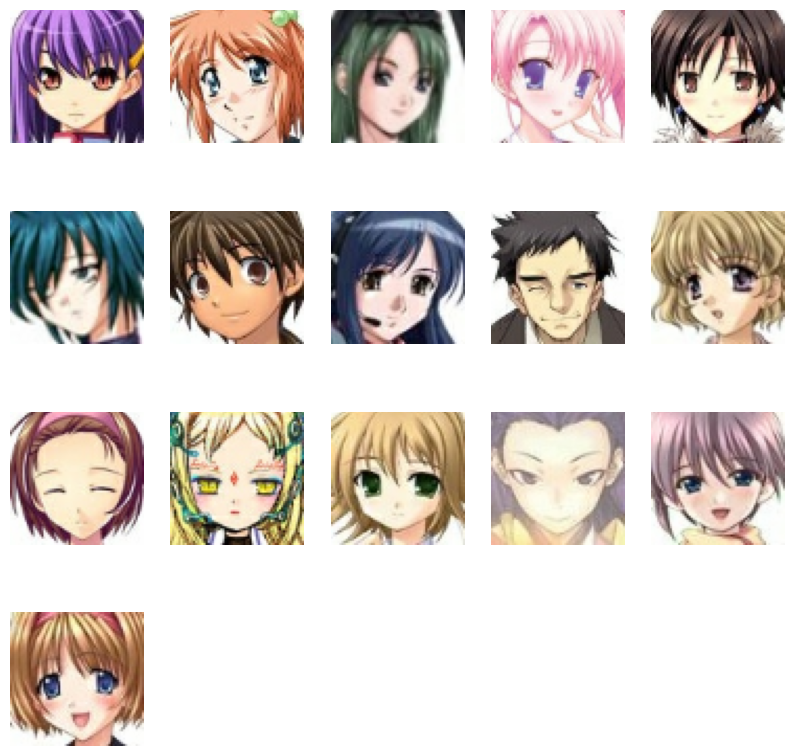

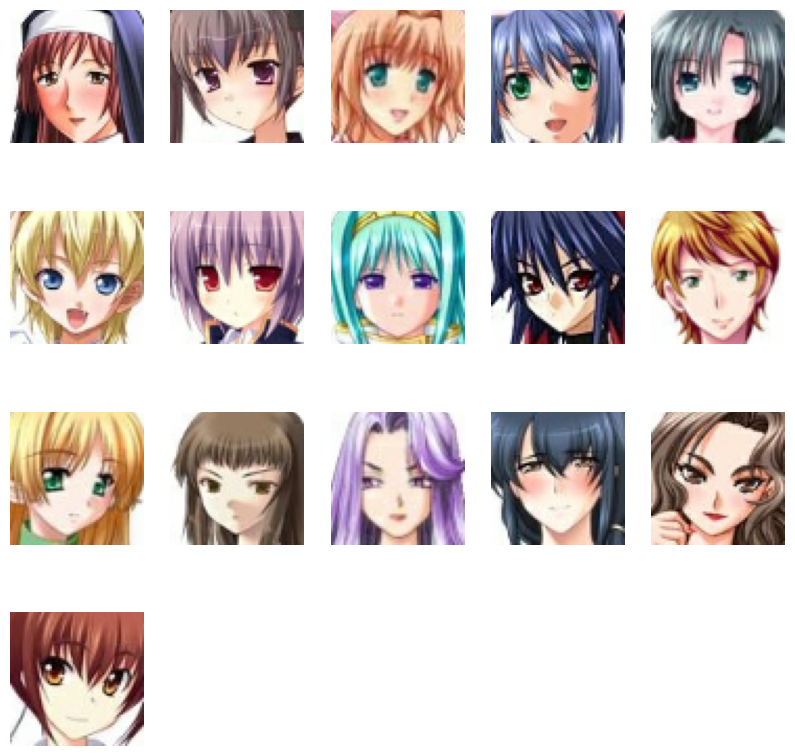

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
from functools import partial

# Yüklenen veri yükleyiciyi kullanarak görüntüleri göstermek için fonksiyon
def show_images(images, num_images):
    num_rows = num_images // 5 + int(num_images % 5 != 0)  # Görüntü sayısına bağlı olarak satır sayısı
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        ax = plt.subplot(num_rows, 5, i + 1)  # Dinamik olarak satır sayısını ayarla
        plt.imshow((images[i].numpy() + 1.0) / 2.0)  # Görüntüyü göster
        plt.axis("off")
    plt.show()

# Veri yükleyiciden batch alıp gösterme
for images in dataloader.take(3):
    show_images(images, images.shape[0])  # Her batch'in kendi boyutunu kullan

In [ ]:
def plot_images(images, log2_res, fname=""):
    #log2 çözünürlük değerine göre çarpanı belirler
    scales = {2: 0.5, 3: 1, 4: 2, 5: 3, 6: 4, 7: 5, 8: 6, 9: 7, 10: 8}
    # Gelen log2 çözünürlük değerine uygun çarpanı alır.
    scale = scales[log2_res]

    # En fazla 32 / scale olacak şekilde ızgara sütun sayısını belirler.
    grid_col = min(images.shape[0], int(32 // scale))
    # Izgara satır sayısını 1 olarak belirler.
    grid_row = 1

    # Izgara düzeninde subplot oluşturur. Her subplot boyutunu çarpan ile belirlenen değere göre ayarlar.
    f, axarr = plt.subplots(
        grid_row, grid_col, figsize=(grid_col * scale, grid_row * scale)
    )

    for row in range(grid_row):
        ax = axarr if grid_row == 1 else axarr[row]
        for col in range(grid_col):
            ax[col].imshow(images[row * grid_col + col])
            ax[col].axis("off")
    plt.show()
    # Eğer dosya adı verilmişse, oluşturulan görseli bu dosya adı ile kaydeder.
    if fname:
        f.savefig(fname)

In [ ]:
#İki girdi tensörü (a ve b) arasında doğrusal bir interpolasyon (geçiş) yapar.
#alpha değeri, bu iki tensör arasındaki geçişin miktarını belirler; 0'da tamamen b, 1'de tamamen a olur.
def fade_in(alpha, a, b):
    return alpha * a + (1. - alpha) * b

#modelin gerçek ve üretilmiş veriler arasındaki "toprak taşıma" mesafesini azaltmayı hedefler.
def wasserstein_loss(y_true, y_pred):
    return -tf.reduce_mean(y_true * y_pred)

#modelin daha kararlı öğrenmesine yardımcı olur
def pixel_norm(x, epsilon=1e-8):
    return x / tf.math.sqrt(tf.reduce_mean(x**2, axis=-1, keepdims=True) + epsilon)

#Girdi tensörünün minibatchler üzerinde standart sapmasını hesaplar ve bu değeri girdi tensörüne ekler.
#Bu işlem, modelin çeşitliliği artırarak mode collapse (modelin hep aynı çıktıyı üretmesi) sorununu azaltmaya yardımcı olur.
def minibatch_std(input_tensor, epsilon=1e-8):
    n, h, w, c = tf.shape(input_tensor)
    group_size = tf.minimum(4, n)
    x = tf.reshape(input_tensor, [group_size, -1, h, w, c])
    group_mean, group_var = tf.nn.moments(x, axes=(0), keepdims=False)
    group_std = tf.sqrt(group_var + epsilon)
    avg_std = tf.reduce_mean(group_std, axis=[1,2,3], keepdims=True)
    x = tf.tile(avg_std, [group_size, h, w, 1])
    return tf.concat([input_tensor, x], axis=-1)

#Eşitlenmiş öğrenme hızı ile evrişim katmanını tanımlar
#Bu, ağırlıkların ölçeklenmesini düzenleyerek, ağırlık başlatmasının öğrenme sürecine etkisini azaltır.
class EqualizedConv(layers.Layer):
    def __init__(self, out_channels, kernel=3, gain=2, **kwargs):
        super(EqualizedConv, self).__init__(**kwargs)
        self.kernel = kernel
        self.out_channels = out_channels
        self.gain = gain
        self.pad = kernel!=1

    def build(self, input_shape):
        self.in_channels = input_shape[-1]
        initializer = keras.initializers.RandomNormal(mean=0., stddev=1.)
        self.w = self.add_weight(shape=[self.kernel,
                                        self.kernel,
                                        self.in_channels,
                                        self.out_channels],
                                initializer=initializer,
                                trainable=True, name='kernel')
        self.b = self.add_weight(shape=(self.out_channels,),
                                initializer='zeros',
                                trainable=True, name='bias')
        fan_in = self.kernel*self.kernel*self.in_channels
        self.scale = tf.sqrt(self.gain/fan_in)

    def call(self, inputs):
        if self.pad:
            x = tf.pad(inputs, [[0, 0], [1, 1], [1, 1], [0, 0]], mode='REFLECT')
        else:
            x = inputs
        output = tf.nn.conv2d(x, self.scale*self.w, strides=1, padding="VALID") + self.b
        return output

#Eşitlenmiş öğrenme hızı ile yoğun (tam bağlantılı) katmanını tanımlar.
#Benzer şekilde, ağırlıkların ölçeklenmesiyle öğrenme sürecini düzenler.
class EqualizedDense(layers.Layer):
    def __init__(self, units, gain=2, learning_rate_multiplier=1, **kwargs):
        super(EqualizedDense, self).__init__(**kwargs)
        self.units = units
        self.gain = gain
        self.learning_rate_multiplier = learning_rate_multiplier

    def build(self, input_shape):
        self.in_channels = input_shape[-1]
        initializer = keras.initializers.RandomNormal(mean=0., stddev=1./self.learning_rate_multiplier)
        self.w = self.add_weight(shape=[self.in_channels,
                                        self.units],
                                initializer=initializer,
                                trainable=True, name='kernel')
        self.b = self.add_weight(shape=(self.units,),
                                initializer='zeros',
                                trainable=True, name='bias')
        fan_in = self.in_channels
        self.scale = tf.sqrt(self.gain/fan_in)

    def call(self, inputs):
        output = tf.add(tf.matmul(inputs, self.scale*self.w), self.b)
        return output*self.learning_rate_multiplier

#Her özellik haritasına öğrenilebilir ağırlıklarla gürültü ekler.
#Bu, modelin ürettiği görüntülerin detaylarını zenginleştirmeye yardımcı olur.
class AddNoise(layers.Layer):

    def build(self, input_shape):
        n, h, w, c = input_shape[0]
        initializer = keras.initializers.RandomNormal(mean=0., stddev=1.)
        self.b = self.add_weight(shape=[1, 1, 1, c],
                                initializer=initializer,
                                trainable=True, name='kernel')

    def call(self, inputs):
        x, noise = inputs
        output = x + self.b * noise
        return output

#Adaptive Instance Normalization işlemi uygular.
#Bu, stil transferi ve varyasyonlu görüntü üretimi için önemlidir
class AdaIN(layers.Layer):
    def __init__(self, gain=1, **kwargs):
        super(AdaIN, self).__init__(**kwargs)
        self.gain = gain

    def build(self, input_shapes):
        x_shape = input_shapes[0]
        w_shape = input_shapes[1]

        self.w_channels = w_shape[-1]
        self.x_channels = x_shape[-1]

        self.dense_1 = EqualizedDense(self.x_channels, gain=1)
        self.dense_2 = EqualizedDense(self.x_channels, gain=1)

    def call(self, inputs):
        x, w = inputs
        ys = tf.reshape(self.dense_1(w), (-1, 1, 1, self.x_channels))
        yb = tf.reshape(self.dense_2(w), (-1, 1, 1, self.x_channels))
        return ys*x + yb

In [ ]:
#Ağ, gürültü vektörleri olarak kabul edilen z girişlerini, modelin geri kalanı tarafından kullanılan w uzayına dönüştürür
def Mapping(num_stages, input_shape=512):
    z = layers.Input(shape=(input_shape))
    w = pixel_norm(z)
    for i in range(8):
        w = EqualizedDense(512, learning_rate_multiplier=0.01)(w)
        w = layers.LeakyReLU(0.2)(w)
    w = tf.tile(tf.expand_dims(w, 1), (1, num_stages, 1))
    return keras.Model(z, w, name="mapping")


class Generator:
    #Başlangıç ve hedef çözünürlük logaritmalarını (start_res_log2, target_res_log2) alır ve bu çözünürlükler arasında kaç aşama olacağını hesaplar (num_stages).
    def __init__(self, start_res_log2, target_res_log2):
        self.start_res_log2 = start_res_log2
        self.target_res_log2 = target_res_log2
        self.num_stages = target_res_log2 - start_res_log2 + 1
        # list of generator blocks at increasing resolution
        self.g_blocks = []
        # list of layers to convert g_block activation to RGB
        self.to_rgb = []
        # list of noise input of different resolutions into g_blocks
        self.noise_inputs = []
        # filter size to use at each stage, keys are log2(resolution)
        self.filter_nums = {
            0: 512,
            1: 512,
            2: 512,  # 4x4
            3: 512,  # 8x8
            4: 512,  # 16x16
            5: 512,  # 32x32
            6: 256,  # 64x64
            7: 128,  # 128x128
            8: 64,  # 256x256
            9: 32,  # 512x512
            10: 16,
        }  # 1024x1024

        start_res = 2 ** start_res_log2
        self.input_shape = (start_res, start_res, self.filter_nums[start_res_log2])
        self.g_input = layers.Input(self.input_shape, name="generator_input")

        for i in range(start_res_log2, target_res_log2 + 1):
            filter_num = self.filter_nums[i]
            res = 2 ** i
            self.noise_inputs.append(
                layers.Input(shape=(res, res, 1), name=f"noise_{res}x{res}")
            )
            to_rgb = Sequential(
                [
                    layers.InputLayer(input_shape=(res, res, filter_num)),
                    EqualizedConv(3, 1, gain=1),
                ],
                name=f"to_rgb_{res}x{res}",
            )
            self.to_rgb.append(to_rgb)
            is_base = i == self.start_res_log2
            if is_base:
                input_shape = (res, res, self.filter_nums[i - 1])
            else:
                input_shape = (2 ** (i - 1), 2 ** (i - 1), self.filter_nums[i - 1])
            g_block = self.build_block(
                filter_num, res=res, input_shape=input_shape, is_base=is_base
            )
            self.g_blocks.append(g_block)

    #Bir çözünürlük değeri (res), filtre sayısı (filter_num), giriş şekli (input_shape) ve temel blok mu değil mi (is_base) bilgisini alır.
    def build_block(self, filter_num, res, input_shape, is_base):
        input_tensor = layers.Input(shape=input_shape, name=f"g_{res}")
        noise = layers.Input(shape=(res, res, 1), name=f"noise_{res}")
        w = layers.Input(shape=512)
        x = input_tensor

        #Eğer blok temel blok değilse, önceki bloktan çıkan çıkışı büyüterek (UpSampling2D) yeni katmana uygun hale getirir.
        if not is_base:
            x = layers.UpSampling2D((2, 2))(x)
            x = EqualizedConv(filter_num, 3)(x)

        x = AddNoise()([x, noise])
        x = layers.LeakyReLU(0.2)(x)
        x = InstanceNormalization()(x)
        x = AdaIN()([x, w])

        x = EqualizedConv(filter_num, 3)(x)
        x = AddNoise()([x, noise])
        x = layers.LeakyReLU(0.2)(x)
        x = InstanceNormalization()(x)
        x = AdaIN()([x, w])
        return keras.Model([input_tensor, w, noise], x, name=f"genblock_{res}x{res}")

    #Model, bir önceki aşamanın RGB çıktısını büyütür ve mevcut aşamanın RGB çıktısıyla birlikte bir geçiş (fade in) uygular,
    #böylece çözünürlük yükseldikçe görüntü yavaşça güncellenir.
    def grow(self, res_log2):
      res = 2 ** res_log2
    # num_stages'ın tamsayı olduğunun hesabı hesaplanması.
      num_stages = res_log2 - self.start_res_log2 + 1
      w = layers.Input(shape=(self.num_stages, 512), name="w")

      alpha = layers.Input(shape=(1), name="g_alpha")
      x = self.g_blocks[0]([self.g_input, w[:, 0], self.noise_inputs[0]])

      if num_stages == 1:
        rgb = self.to_rgb[0](x)
      else:
        for i in range(1, num_stages - 1):

            x = self.g_blocks[i]([x, w[:, i], self.noise_inputs[i]])

        old_rgb = self.to_rgb[num_stages - 2](x)
        old_rgb = layers.UpSampling2D((2, 2))(old_rgb)

        i = num_stages - 1
        x = self.g_blocks[i]([x, w[:, i], self.noise_inputs[i]])

        new_rgb = self.to_rgb[i](x)
        rgb = fade_in(alpha[0], new_rgb, old_rgb)  # alpha[0] kaldırıldı, eğer alpha zaten skaler girdi ise

      return keras.Model(
        [self.g_input, w, self.noise_inputs, alpha],
        rgb,
        name=f"generator_{res}x{res}",
    )

    # Örnek generate metodu
    def generate(self):
        # Burada üretilen görüntüyü simüle ediyorum
        return np.random.rand(256, 256, 3)  # Rastgele bir görüntü döndür


#Discriminator bölümü, gerçek görüntüler ile sahte görüntüler arasındaki farkı ayırt etmek için kullanılır
class Discriminator:
    #çözünürlüklerini aşamalı olarak artırarak modelin daha etkin öğrenmesini sağlar
    def __init__(self, start_res_log2, target_res_log2):
        self.start_res_log2 = start_res_log2
        self.target_res_log2 = target_res_log2
        self.num_stages = target_res_log2 - start_res_log2 + 1    #Başlangıç çözünürlüğünden hedef çözünürlüğe kadar olan aşama sayısı
        # filter size to use at each stage, keys are log2(resolution)
        self.filter_nums = {      #Her çözünürlük aşaması için kullanılacak filtre sayısını belirleyen sözlük yapısı.
            0: 512,
            1: 512,
            2: 512,  # 4x4
            3: 512,  # 8x8
            4: 512,  # 16x16
            5: 512,  # 32x32
            6: 256,  # 64x64
            7: 128,  # 128x128
            8: 64,  # 256x256
            9: 32,  # 512x512
            10: 16,
        }  # 1024x1024
        # list of discriminator blocks at increasing resolution
        self.d_blocks = []
        # list of layers to convert RGB into activation for d_blocks inputs
        self.from_rgb = []

        for res_log2 in range(self.start_res_log2, self.target_res_log2 + 1):
            res = 2 ** res_log2
            filter_num = self.filter_nums[res_log2]
            from_rgb = Sequential(
                [
                    layers.InputLayer(
                        input_shape=(res, res, 3), name=f"from_rgb_input_{res}"
                    ),
                    EqualizedConv(filter_num, 1),
                    layers.LeakyReLU(0.2),
                ],
                name=f"from_rgb_{res}",
            )

            self.from_rgb.append(from_rgb)

            input_shape = (res, res, filter_num)
            if len(self.d_blocks) == 0:
                d_block = self.build_base(filter_num, res)
            else:
                d_block = self.build_block(
                    filter_num, self.filter_nums[res_log2 - 1], res
                )

            self.d_blocks.append(d_block)

    #Discriminator'un en son katmanını oluşturur. Bu katman, sonucu (gerçek veya sahte) tek bir değer olarak verir.
    def build_base(self, filter_num, res):
        input_tensor = layers.Input(shape=(res, res, filter_num), name=f"d_{res}")
        x = minibatch_std(input_tensor)
        x = EqualizedConv(filter_num, 3)(x)
        x = layers.LeakyReLU(0.2)(x)
        x = layers.Flatten()(x)
        x = EqualizedDense(filter_num)(x)
        x = layers.LeakyReLU(0.2)(x)
        x = EqualizedDense(1)(x)
        return keras.Model(input_tensor, x, name=f"d_{res}")

    #Standart discriminator bloğunu oluşturur.
    def build_block(self, filter_num_1, filter_num_2, res):
        input_tensor = layers.Input(shape=(res, res, filter_num_1), name=f"d_{res}")
        x = EqualizedConv(filter_num_1, 3)(input_tensor)
        x = layers.LeakyReLU(0.2)(x)
        x = EqualizedConv(filter_num_2)(x)
        x = layers.LeakyReLU(0.2)(x)
        x = layers.AveragePooling2D((2, 2))(x)
        return keras.Model(input_tensor, x, name=f"d_{res}")

    #Modelin çözünürlüğünü artırırken eski çözünürlükten yeni çözünürlüğe yumuşak bir geçiş yapılmasını sağlar
    def grow(self, res_log2):
        res = 2 ** res_log2
        idx = res_log2 - self.start_res_log2
        alpha = layers.Input(shape=(1), name="d_alpha")
        input_image = layers.Input(shape=(res, res, 3), name="input_image")
        x = self.from_rgb[idx](input_image)
        x = self.d_blocks[idx](x)
        if idx > 0:
            idx -= 1
            downsized_image = layers.AveragePooling2D((2, 2))(input_image)
            y = self.from_rgb[idx](downsized_image)
            x = fade_in(alpha[0], x, y)

            for i in range(idx, -1, -1):
                x = self.d_blocks[i](x)
        return keras.Model([input_image, alpha], x, name=f"discriminator_{res}_x_{res}")

In [ ]:
#StyleGAN modelinin ana bileşenlerini ve yapılandırmasını kurma işlemleri.
class StyleGAN(tf.keras.Model):

    def __init__(self, z_dim=512, target_res=64, start_res=4):
        super(StyleGAN, self).__init__()
        self.z_dim = z_dim      #z_dim, latent vektör (gürültü vektörü) boyutu

        #Modelinin başlangıç ve hedef çözünürlüğü.Modelin çözünürlüğünün 2'nin kuvvetleri şeklinde olduğunu kabul ediyoruz.
        self.target_res_log2 = log2(target_res)
        self.start_res_log2 = log2(start_res)
        self.current_res_log2 = self.target_res_log2
        self.num_stages = self.target_res_log2 - self.start_res_log2 + 1

        #alpha: Mevcut eğitim aşamasında, yeni eklenen katmanların eski katmanlarla karışımını kontrol eden bir değerdir.
        #Yeni katmanlar tamamen entegre olana kadar bu değer yavaş yavaş 1'den 0'a düşer.
        self.alpha = tf.Variable(1., dtype=tf.float32, trainable=False, name='alpha')

        self.mapping = Mapping(num_stages=self.num_stages)
        self.d_builder = Discriminator(self.start_res_log2, self.target_res_log2)
        self.g_builder = Generator(self.start_res_log2, self.target_res_log2)
        self.g_input_shape = self.g_builder.input_shape

        self.phase = None
        self.train_step_counter = tf.Variable(0, dtype=tf.int32, trainable=False)

        self.loss_weights = {'gradient_penalty':10, 'drift':0.001}

    #Eğitim farklı çözünürlükler boyunca ilerledikçe jeneratör ve diskriminatöre yeni katmanlar eklenmesini yönetir.
    def grow_model(self, res):
        tf.keras.backend.clear_session()
        res_log2 = log2(res)
        self.generator = self.g_builder.grow(res_log2)
        self.discriminator = self.d_builder.grow(res_log2)
        self.current_res_log2 = res_log2
        print(f"\nModel resolution:{res}x{res}")

    #Kayıp ağırlıkları ve diğer ayarlarla eğitim için modeli hazırlar.
    def compile(self, steps_per_epoch, phase, res, d_optimizer, g_optimizer,
                *args, **kwargs):
        self.loss_weights = kwargs.pop('loss_weights',self.loss_weights)
        self.steps_per_epoch = steps_per_epoch
        if res != 2**self.current_res_log2:
            self.grow_model(res)
            self.d_optimizer = d_optimizer
            self.g_optimizer = g_optimizer

        self.train_step_counter.assign(0)
        self.phase = phase
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")
        super(StyleGAN, self).compile(*args, **kwargs)

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    #Jeneratörün progresif büyüme mimarisini destekleyen her aşama için bir gürültü girdileri listesi üretir.
    def generate_noise(self, batch_size):
        noise = [tf.random.normal((batch_size, 2**res, 2**res, 1)) \
                 for res in range(self.start_res_log2, self.target_res_log2+1)]
        return noise

    #Pürüzsüz gradyanları eğitim istikrarını iyileştirmek için gradyan cezasını hesaplar.
    def gradient_loss(self, grad):
        loss = tf.square(grad)
        loss = tf.reduce_sum(loss, axis=tf.range(1,tf.size(tf.shape(loss))))
        loss = tf.sqrt(loss)
        loss = tf.reduce_mean(tf.square(loss - 1))
        return loss

    #Eğitim adımı
    def train_step(self, real_images):

        self.train_step_counter.assign_add(1)

        if self.phase == 'TRANSITION':
            self.alpha.assign(tf.cast(self.train_step_counter/self.steps_per_epoch, tf.float32))
        elif self.phase == 'STABLE':
            self.alpha.assign(1.)
        else:
            raise NotImplementedError
        alpha = tf.expand_dims(self.alpha, 0)
        batch_size = tf.shape(real_images)[0]
        real_labels = tf.ones(batch_size)
        fake_labels = -tf.ones(batch_size)

        z = tf.random.normal((batch_size, self.z_dim))
        const_input = tf.ones(tuple([batch_size]+list(self.g_input_shape)))
        noise = self.generate_noise(batch_size)

        #Eğitim verileri jeneratör ve diskriminatör üzerinden işlenir, her biri için gradyanlar hesaplanır ve uygulanır

        # generator
        with tf.GradientTape() as g_tape:
            w = self.mapping(z)
            fake_images = self.generator([const_input, w, noise, alpha])
            pred_fake = self.discriminator([fake_images, alpha])
            g_loss = wasserstein_loss(real_labels, pred_fake)

            trainable_weights = self.mapping.trainable_weights + self.generator.trainable_weights
            gradients = g_tape.gradient(g_loss, trainable_weights)
            self.g_optimizer.apply_gradients(zip(gradients, trainable_weights))

        # discriminator
        with tf.GradientTape() as gradient_tape,\
             tf.GradientTape() as total_tape:
            # forward pass
            pred_fake = self.discriminator([fake_images, alpha])
            pred_real = self.discriminator([real_images, alpha])

            epsilon = tf.random.uniform((batch_size,1,1,1))
            interpolates = epsilon*real_images + (1-epsilon)*fake_images
            gradient_tape.watch(interpolates)
            pred_fake_grad = self.discriminator([interpolates, alpha])

            # calculate losses
            loss_fake = wasserstein_loss(fake_labels, pred_fake)
            loss_real = wasserstein_loss(real_labels, pred_real)
            loss_fake_grad = wasserstein_loss(fake_labels, pred_fake_grad)

            # gradient penalty
            gradients_fake = gradient_tape.gradient(loss_fake_grad, [interpolates])
            gradient_penalty = self.loss_weights['gradient_penalty'] * self.gradient_loss(gradients_fake)

            # drift loss
            all_pred = tf.concat([pred_fake, pred_real], axis=0)
            drift_loss = self.loss_weights['drift'] * tf.reduce_mean(all_pred**2)

            d_loss = loss_fake + loss_real + gradient_penalty + drift_loss

            gradients = total_tape.gradient(d_loss, self.discriminator.trainable_weights)
            self.d_optimizer.apply_gradients(zip(gradients, self.discriminator.trainable_weights))

        #Metricleri güncelleme
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

    #Modelden görüntüler üretme
    def call(self, inputs:dict()):
        style_code = inputs.get('style_code', None)
        z = inputs.get('z', None)
        noise = inputs.get('noise', None)
        batch_size = inputs.get('batch_size', 1)
        alpha = inputs.get('alpha', 1.0)
        alpha = tf.expand_dims(alpha, 0)
        if style_code is None:
            if z is None:
                z = tf.random.normal((batch_size, self.z_dim))
            style_code = self.mapping(z)

        if noise is None:
            noise = self.generate_noise(batch_size)

        #self.alpha.assign(alpha)

        const_input = tf.ones(tuple([batch_size]+list(self.g_input_shape)))
        images = self.generator([const_input, style_code, noise, alpha])
        images = np.clip((images*0.5 + 0.5)*255, 0, 255).astype(np.uint8)

        return images

In [ ]:
#StyleGAN sınıfının bir örneğini oluşturma
START_RES = 4   #Başlangıç çözünürlüğü
TARGET_RES = 128  #Hedeflenen çözünürlük

style_gan = StyleGAN(start_res=START_RES,
                     target_res=TARGET_RES)

In [ ]:
#Başlangıç çözünürlüğünden başlayarak hedef çözünürlüğe kadar modeli kademeli bir şekilde eğitmektir.
def train(start_res=START_RES, target_res=TARGET_RES, steps_per_epoch=5000, display_images=True):
    #Öğrenme hızı, beta değerleri ve epsilon gibi parametreler ayarlanır.Burada epsilon belirlediğimiz değerler aşağidadir
    opt_cfg = {'learning_rate':1e-3, 'beta_1':0.0, 'beta_2':0.99, 'epsilon':1e-8}

    val_batch_size = 16
    #Modelin çıktılarını doğrulamak için kullanılacak olan gürültü ve Z vektörleridir.Bu vektörler sabittir.
    val_z = tf.random.normal((val_batch_size, style_gan.z_dim))
    val_noise = style_gan.generate_noise(val_batch_size)

    #Başlangıç ve hedef çözünürlüklerin logaritmik değerlerini hesaplar.
    start_res_log2 = int(np.log2(start_res))
    target_res_log2 = int(np.log2(target_res))

    #Eğitim döngüsü, farklı çözünürlük seviyeleri için döngü içerisinde eğitim gerçekleştirilir
    for res_log2 in range(start_res_log2, target_res_log2+1):
        res = 2**res_log2
        #Her bir çözünürlük seviyesinde, TRANSITION ve STABLE fazları için eğitim yapılır.
        for phase in ['TRANSITION', 'STABLE']:      #STABLE fazı, yeni çözünürlük seviyesinde modelin daha kararlı hale gelmesi için kullanılır.
            #TRANSITION fazı, yeni eklenen çözünürlük seviyesine geçişin yumuşak olmasını sağlamak için alpha karışımı ile yeni ve eski çözünürlük katmanlarını birleştirir.
            if res==start_res and phase=='TRANSITION':
                continue

            train_dl = create_dataloader(res)

            steps = int(train_step_ratio[res_log2] * steps_per_epoch)

            #Modeli belirli bir çözünürlük ve faz için derler. Modelin kayıp fonksiyonları, optimizer'lar ve diğer parametreler bu aşamada belirlenir.
            style_gan.compile(d_optimizer=tf.keras.optimizers.Adam(**opt_cfg),
                              g_optimizer=tf.keras.optimizers.Adam(**opt_cfg),
                              loss_weights = {'gradient_penalty':10, 'drift':0.001},
                              steps_per_epoch=steps,
                              res=res,
                              phase=phase, run_eagerly=False)

            prefix = f'res_{res}x{res}_{style_gan.phase}'

            #Model eğitilir ve her eğitim döngüsü sonunda ModelCheckpoint callback'i ile model ağırlıkları kaydedilir.
            ckpt_cb = keras.callbacks.ModelCheckpoint(f'checkpoints/stylegan_{res}x{res}.ckpt',
                                      save_weights_only=True, verbose=0)
            print(phase)

            style_gan.fit(train_dl, epochs=1,
                          steps_per_epoch=steps, callbacks=[ckpt_cb])

            if display_images:      #True ise, eğitim sırasında üretilen görüntüler gösterilir.
                images = style_gan({'z':val_z, 'noise':val_noise, 'alpha':1.0})
                plot_images(images, res_log2)

STABLE
1000/1000 [==============================] - 2145s 2s/step - d_loss: -11.1658 - g_loss: 12.1269


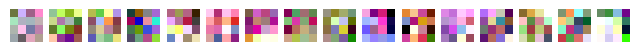


Model resolution:8x8
TRANSITION
1000/1000 [==============================] - 105s 91ms/step - d_loss: -15.2816 - g_loss: 13.4404


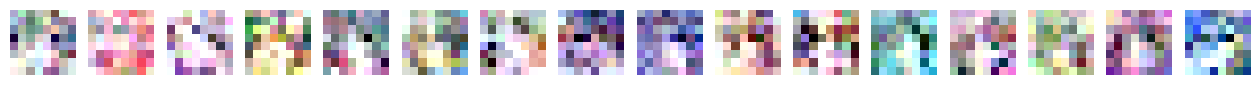

STABLE
1000/1000 [==============================] - 96s 90ms/step - d_loss: -10.0534 - g_loss: 7.2944


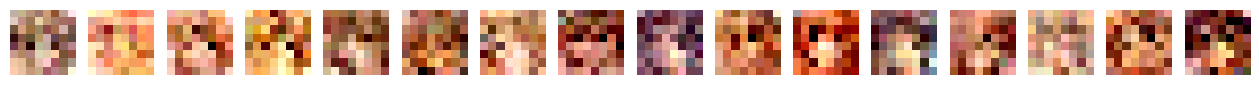


Model resolution:16x16
TRANSITION
1000/1000 [==============================] - 215s 197ms/step - d_loss: -18.9466 - g_loss: 17.3965


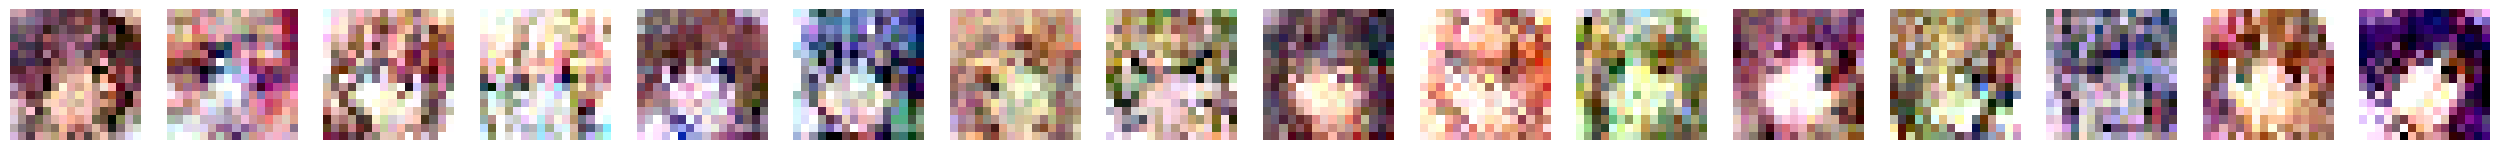

STABLE
1000/1000 [==============================] - 202s 197ms/step - d_loss: -12.7989 - g_loss: 10.1458


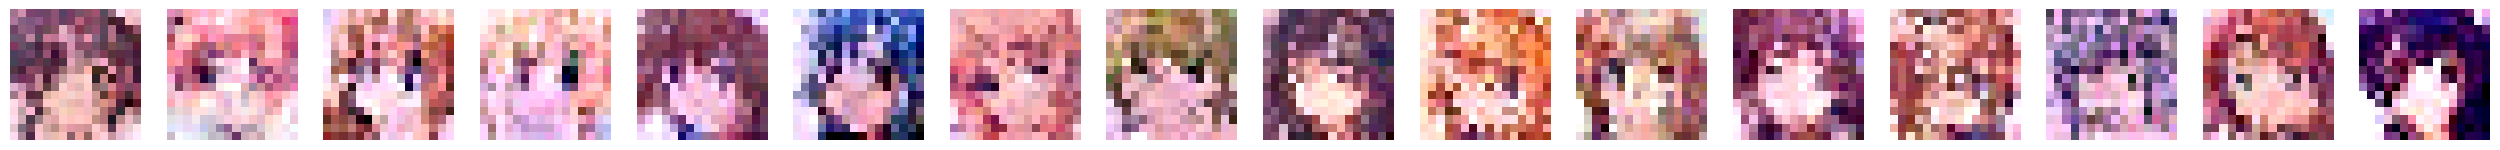


Model resolution:32x32
TRANSITION
1000/1000 [==============================] - 536s 511ms/step - d_loss: -28.9608 - g_loss: 24.4702


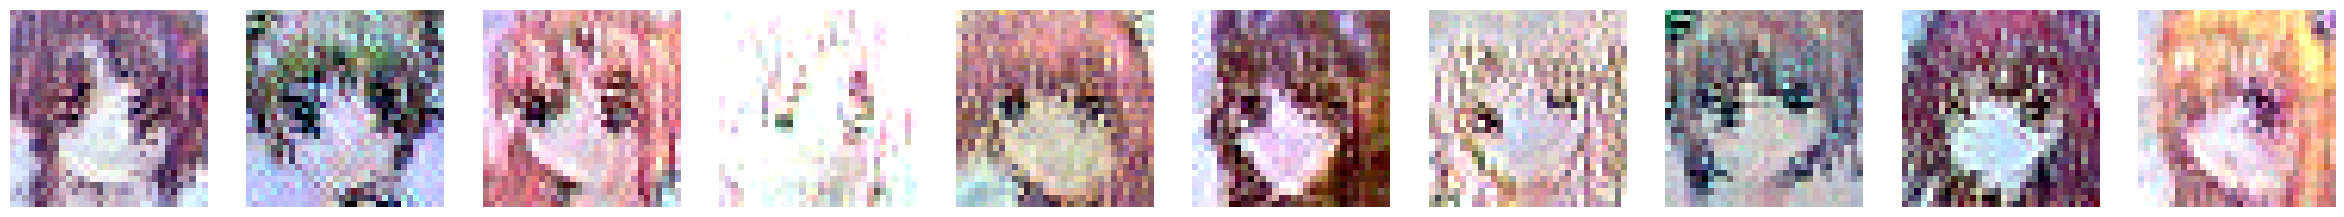

STABLE
1000/1000 [==============================] - 522s 515ms/step - d_loss: -22.9836 - g_loss: 15.3482


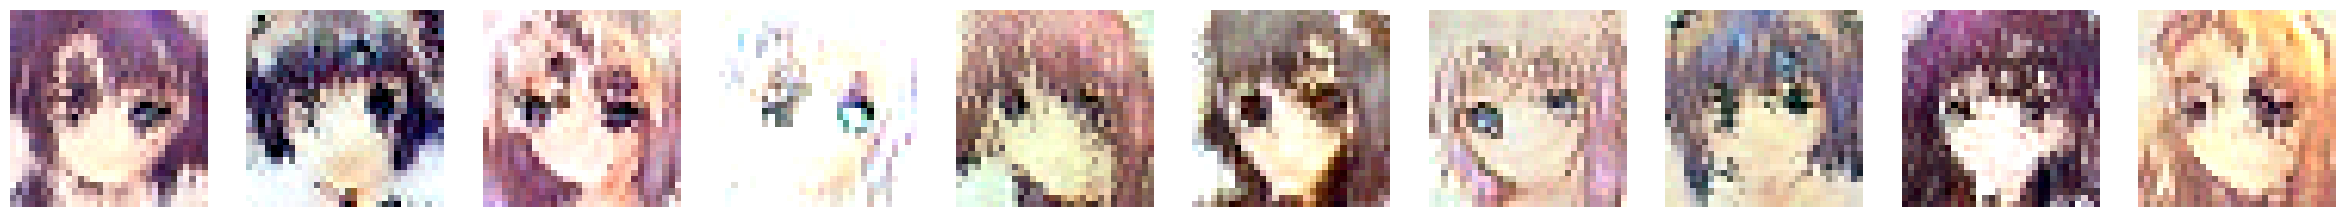


Model resolution:64x64
TRANSITION
1000/1000 [==============================] - 1097s 1s/step - d_loss: -58.3172 - g_loss: 46.7679


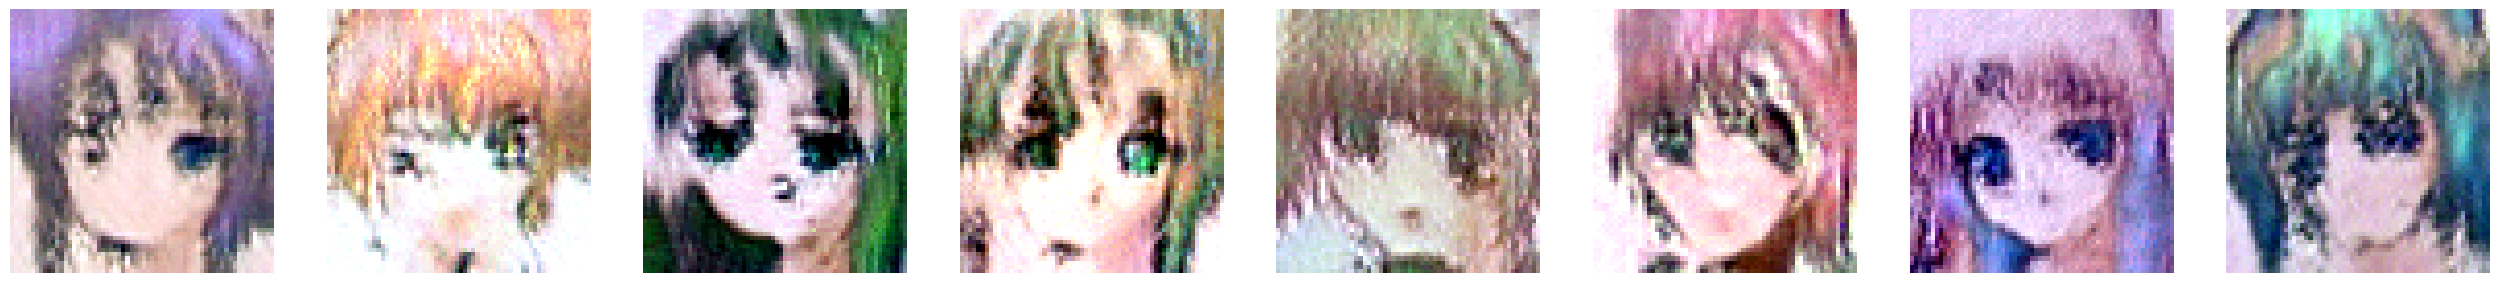

STABLE
1000/1000 [==============================] - 1068s 1s/step - d_loss: -42.5126 - g_loss: 32.5411


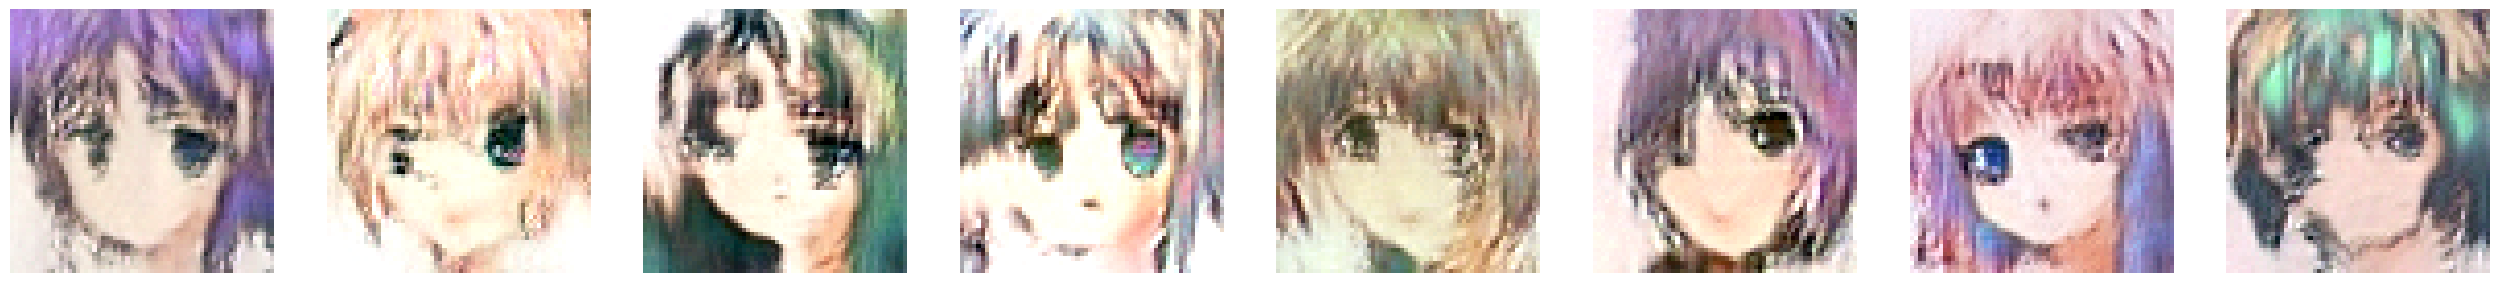


Model resolution:128x128
TRANSITION
2000/2000 [==============================] - 2550s 1s/step - d_loss: -53.2648 - g_loss: 41.4104


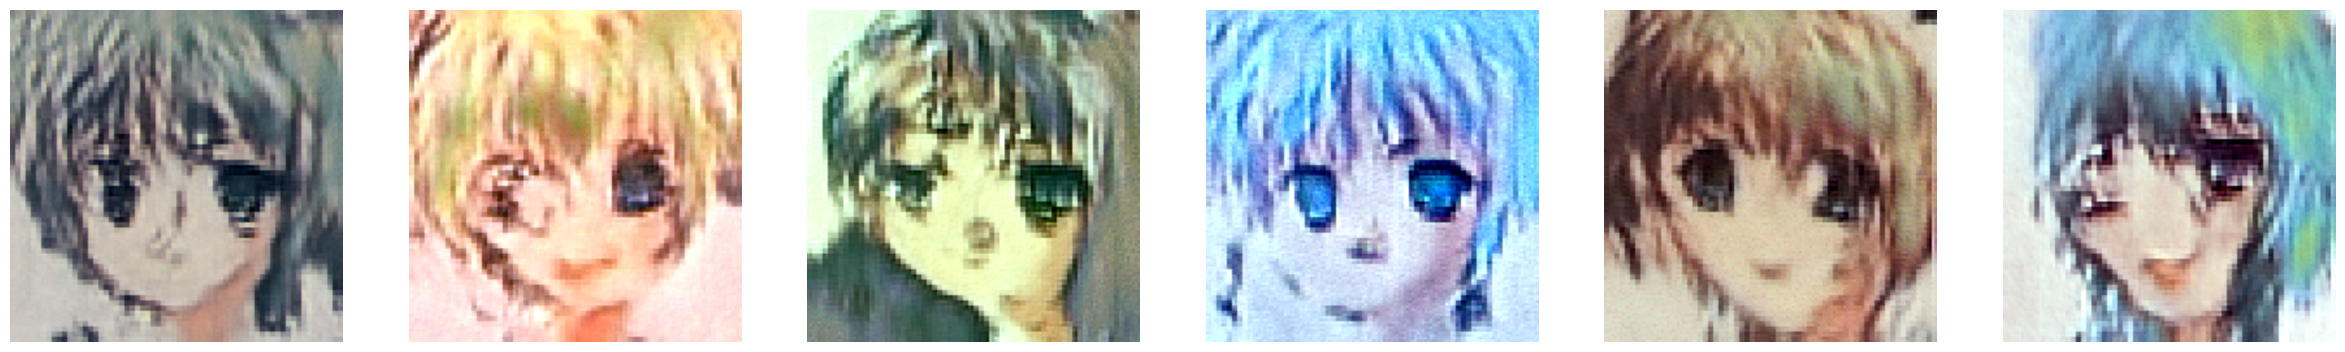

STABLE
2000/2000 [==============================] - ETA: 0s - d_loss: -40.8565 - g_loss: 31.3592

In [ ]:
train(steps_per_epoch=1000)

Dataset İçeriği: https://drive.google.com/drive/u/0/folders/1qrqKuVu6D4c_4wX2lrgOxyb9ivciaPgs

Kaynaklar:

https://machinelearningmastery.com/introduction-to-style-generative-adversarial-network-stylegan/

https://keras.io/examples/generative/stylegan/

https://www.kaggle.com/datasets/splcher/animefacedataset

https://paperswithcode.com/method/stylegan

